3a. 

i. The authors have used the `a trous algorithm to keep the size of the original image intact. Upsampling reproduces the full net output
which involves repeating filter enlargement layer by layer until all subsampling is removed. In practice, this can be done efficiently by processing subsampled versions of the upsampled input.
Upsampling with factor f is convolution with a fractional input stride of 1/f. So long as f is integral, a natural way to upsample is therefore backwards convolution with an output stride of f. Such an operation is trivial to implement, since it simply reverses the forward and backward passes of convolution. Thus upsampling is performed in-network for end-to-end learning by backpropagation from the pixelwise loss.

ii. The authors improved the coarse predictions produced by the deepest layer by fusing predictions from pool3 with a 2x upsampling of predictions fused from pool4 and conv7 (convolutionalized fc7), building the net FCN-8s. The output stride is first divided in half by predicting from a 16 pixel stride layer. A 1x1 convolution layer is added on top of pool4 to produce additional class predictions. This output is then fused with the predictions computed on top of conv7 at stride 32 by
adding a 2x upsampling layer and summing both predictions. The 2x upsampling is initialized to bilinear interpolation. Finally, the stride 16 predictions are upsampled back to the image. This is called FCN-16s. FCN-16s is learned end-to-end, initialized with the parameters of the last, coarser net, which is now called FCN-32s. The new parameters acting on pool4 are zero-initialized
so that the net starts with unmodified predictions.

3b. Segmentation

In [0]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import models
import numpy as np
import torchvision.transforms as T
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def decode_segmap(image, nc):
  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
#  for l in range(0, nc):
#      idx = image == l
#      r[idx] = label_colors[l, 0]
#      g[idx] = label_colors[l, 1]
#      b[idx] = label_colors[l, 2]
    
  idx = image == nc
  r[idx] = label_colors[nc, 0]
  g[idx] = label_colors[nc, 1]
  b[idx] = label_colors[nc, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb

In [0]:
#Define mask function
def apply_mask(im, im_pred):
    """
    Overlays the predicted class labels onto an image using the alpha channel.
    This function assumes that the background label is the black color.
    This function is provided as an inspiration for the masking function you should write.
    """
    r_channel, g_channel, b_channel = cv2.split(im_pred)
    
    alpha_channel = 127 * np.ones(b_channel.shape, dtype=b_channel.dtype)
    # Make background pixels fully transparent
    alpha_channel -= 127 * np.all(im_pred == np.array([0, 0, 0]), axis=2).astype(b_channel.dtype)
    g_channel=np.zeros(g_channel.shape, dtype=g_channel.dtype)
    b_channel=np.zeros(b_channel.shape, dtype=b_channel.dtype)
    im_pred = cv2.merge((r_channel, g_channel, b_channel, alpha_channel))
    mask = Image.fromarray(im_pred)
    masked_img = Image.fromarray(im)
    masked_img.paste(mask, box=None, mask=mask)
    return np.array(masked_img)

In [5]:
fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:12<00:00, 14.4MB/s]
Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /root/.cache/torch/checkpoints/fcn_resnet101_coco-7ecb50ca.pth
100%|██████████| 208M/208M [00:03<00:00, 62.6MB/s]


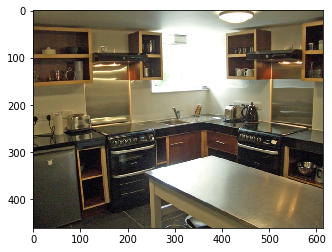

In [6]:
#show original image
img = Image.open('/content/drive/My Drive/Assignment B/Files/CHAKRASA@TCD.IE.png')
plt.imshow(img); plt.show()

In [7]:
trf = T.Compose([T.ToTensor(),
                 T.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])
inp = trf(img).unsqueeze(0)

#out = dlab(inp)['out']
out = fcn(inp)['out']
print (out.shape)

torch.Size([1, 21, 461, 614])


In [8]:
om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print (np.unique(om))

[ 0 11 20]


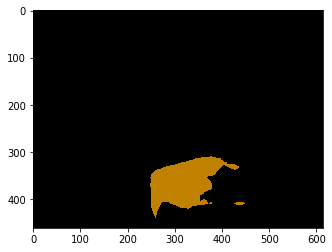

In [9]:
#show mask
rgb = decode_segmap(om,11)
plt.imshow(rgb); plt.show()

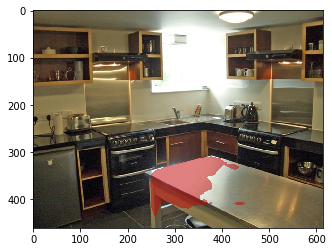

In [10]:
#show masked image blended with the original image
plt.imshow(apply_mask(np.array(img),rgb)); plt.show()

3c. Compute IOU score

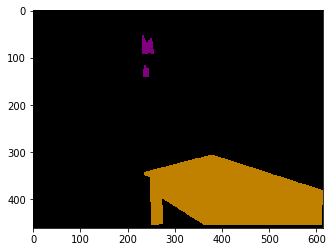

In [11]:
#load groundtruth image
mask = Image.open('/content/drive/My Drive/Assignment B/Files/CHAKRASA@TCD.IE_mask.png')
plt.imshow(mask); plt.show()

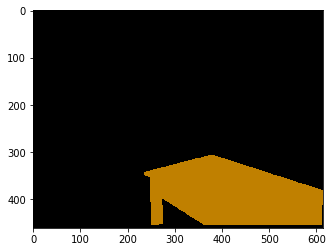

In [12]:
#remove extra elements and keep only the table in groundtruth image
pix=mask.load()
for i in range (np.array(mask).shape[1]):
    for j in range (np.array(mask).shape[0]):
        if not pix[i,j]==(192, 128, 0):
            pix[i,j]=(0,0,0)

plt.imshow(mask); plt.show()

In [13]:
#compute the IOU score between groundtruth image and computed mask
intersection = np.sum(np.logical_and(rgb,np.array(mask)))
union = np.sum( np.logical_or(rgb,np.array(mask)))   
iou_score = intersection/union
print(iou_score)

0.3009358549424839


REFERENCES:
1. Fully Convolutional Networks for Semantic
Segmentation (https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf).
2. https://nanonets.com/blog/how-to-do-semantic-segmentation-using-deep-learning/
3. https://heartbeat.fritz.ai/a-2019-guide-to-semantic-segmentation-ca8242f5a7fc#9141

